<a href="https://colab.research.google.com/github/Saveska/LongCovid-Tweets-Analysis/blob/main/Classifying_LongCovid_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classify #LongCovid tweets into different categories, such as symptoms, treatments, personal experiences, or scientific research

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from gensim.models import Word2Vec
from sklearn.metrics import classification_report

import re
import tqdm
import nltk # for tokenization
import spacy
import string

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/lc2022.csv')

In [4]:
data

,Date,User,Tweets
0,2022-01-31 23:59:18+00:00,RobocapFriend,@kathymi71147962 @RiaRex2 My s-in-law had Covi...
1,2022-01-31 23:59:18+00:00,LupusWarrior69,@MarinaSilver6 Long COVID sucks. But you make ...
2,2022-01-31 23:58:12+00:00,ElsaOrgana,@PortiaMcGonagal It’s been one for about a mon...
3,2022-01-31 23:57:59+00:00,WilliamAHirsch,Living with covid also means lifelong health p...
4,2022-01-31 23:57:58+00:00,persistingvirus,Long Covid. Scientists agreed leading theory i...
...,...,...,...
1465845,2022-09-01 00:00:53+00:00,Suemonti57,@SteveBigpond @mjrowland68 How many times are ...
1465846,2022-09-01 00:00:38+00:00,KariDru,Longcovid life: my kettle beeped and Fenris se...
1465847,2022-09-01 00:00:18+00:00,twogukuk,@kksheld Have you seen the symptoms of long co...
1465848,2022-09-01 00:00:00+00:00,getvaxxedpeople,Millions can't work because of long Covid.\n\n...


## Data preparation

### Removing NAN values

In [5]:
data.isna().sum()

Date      0
User      4
Tweets    4
dtype: int64

In [6]:
data = data.dropna()

In [7]:
data.isna().sum()

Date      0
User      0
Tweets    0
dtype: int64

### Data cleaning

In [8]:
# Calculate the sum of each words in tweets
from collections import Counter
from nltk.corpus import stopwords

nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [9]:
df = data.copy()

In [10]:
all_words=[word for tweet in df['Tweets'] for word in tweet.split(" ") ]

In [11]:
vocab = Counter(all_words)

In [12]:
print('Least Common')
vocab.most_common()[-10:]

Least Common


[('.\n\nLike', 1),
 ('anyway?\nScam.', 1),
 ('\n\n"Compared', 1),
 ('(n\u2009=\u2009113,474)', 1),
 ('risks...incident', 1),
 ('0.89)"\n\nhttps://t.co/jyMoUy5PZP', 1),
 ('https://t.co/NHiy9N1FJS', 1),
 ('beeped', 1),
 ('Fenris', 1),
 ('Covid.\n\nhttps://t.co/A7zi0s0rcW\n#covid', 1)]

#### Stop words

In [13]:
from nltk.corpus import stopwords
from collections import Counter
stop_words= stopwords.words("english")
stop_words[20:30]

['himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself']

In [14]:
stop_words=stopwords.words("english")
def remove_stop_words(text):
    return " ".join([word for word in text.split(" ") if word not in stop_words])

#### Hashtags

In [15]:
hashtag_re=re.compile(pattern='#[\w\d]+')
def remove_hashtag(text:str)->str:
    return hashtag_re.sub(repl="",string=text)

#### Mentions


In [16]:
mention_re =re.compile('@\w+')
def remove_mention(text):
    return mention_re.sub(repl="",string=text)

#### Punctuation Marks

In [17]:
punc_re = re.compile(r"""[!"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~،؟…«“\":\"…”]""")

def remove_punctation(text:str)->str:
    return punc_re.sub(repl="",string=text)

#### Numbers

In [18]:
number_re=re.compile('\d+')
def remove_numbers(text):
    return number_re.sub(repl='',string=text)

#### White Sapces

In [19]:
multiple_space_re =re.compile('\s{2,}')
def remove_multiple_whitespace(text):
    return multiple_space_re.sub(repl=' ',string=text)

#### HTTP URLs

In [20]:
def remove_urls(text):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))'," ",text)

#### Emojis

In [21]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#### Clean ALL

In [22]:
def clean_all(text):
    text = remove_urls(text)
    text = remove_hashtag(text)
    text = remove_mention(text)
    text = remove_punctation(text)
    text = remove_numbers(text)
    text = remove_stop_words(text)
    text = remove_multiple_whitespace(text)
    text = remove_emojis(text)
    # remove space in beginning of text
    text = text.lower().strip()

    return text

In [23]:
df["Tweets"] = df["Tweets"].apply(clean_all)

In [24]:
df.head(5)

,Date,User,Tweets
0,2022-01-31 23:59:18+00:00,RobocapFriend,my sinlaw covid months ago she still long covi...
1,2022-01-31 23:59:18+00:00,LupusWarrior69,long covid sucks but make look sexy
2,2022-01-31 23:58:12+00:00,ElsaOrgana,it’s one month long covid solidarity one fed l...
3,2022-01-31 23:57:59+00:00,WilliamAHirsch,living covid also means lifelong health proble...
4,2022-01-31 23:57:58+00:00,persistingvirus,long covid scientists agreed leading theory sy...


### Data processing

#### Determining category

To determine in which category a tweet belongs, I am using 'Keyword Matching'. I will create a list of relevant keywords or phrases for each category, then I will use these keywords to match against the text of the tweets. If a tweet contains keywords related to symptoms, treatments, personal experiences, or scientific research, it will be assigned to the corresponding category.

Categories are: symptoms, treatments, personal experiences and scientific research

##### Tokenization and word frequency

In [25]:
# Tokenization and frequency analysis
all_words = ' '.join(df['Tweets']).split()
word_counts = Counter(all_words)

In [26]:
from nltk.probability import FreqDist

# Calculate word frequencies
word_freq = FreqDist(all_words)

In [27]:
# Print the least common words and their frequencies
most_common_words = word_freq.most_common(1000)

print("Most common words and their frequencies:")
for word, count in most_common_words:
    print(f"{word}: {count}", end=', ')

Most common words and their frequencies:
covid: 1451100, long: 1244527, i: 494056, new: 295434, disease: 277446, preprint: 249111, coding: 248118, characterizing: 248115, people: 228020, amp: 161774, get: 140573, the: 116622, symptoms: 105692, know: 99227, like: 98600, many: 93972, still: 87033, one: 75487, even: 71351, risk: 70472, it’s: 68593, also: 68046, health: 66390, dont: 66067, and: 64063, this: 61762, infection: 59929, us: 59263, longcovid: 59255, it: 58823, we: 57720, would: 56332, im: 56298, think: 56120, need: 54676, time: 52212, getting: 51474, don’t: 51176, got: 50035, work: 49954, you: 48883, patients: 47337, much: 47208, i’m: 46263, years: 46086, could: 45200, may: 44398, but: 44054, months: 43969, going: 42640, kids: 42229, help: 42075, if: 41905, study: 41374, really: 41109, want: 40966, so: 40451, research: 40367, children: 40180, well: 40172, vaccine: 39760, cases: 38925, see: 38518, brain: 38054, my: 37963, good: 37920, care: 36589, its: 36575, not: 35906, virus: 3

In [28]:
df

,Date,User,Tweets
0,2022-01-31 23:59:18+00:00,RobocapFriend,my sinlaw covid months ago she still long covi...
1,2022-01-31 23:59:18+00:00,LupusWarrior69,long covid sucks but make look sexy
2,2022-01-31 23:58:12+00:00,ElsaOrgana,it’s one month long covid solidarity one fed l...
3,2022-01-31 23:57:59+00:00,WilliamAHirsch,living covid also means lifelong health proble...
4,2022-01-31 23:57:58+00:00,persistingvirus,long covid scientists agreed leading theory sy...
...,...,...,...
1465844,2022-09-01 00:00:53+00:00,ahandvanish,gotos body politic also put together list trus...
1465845,2022-09-01 00:00:53+00:00,Suemonti57,how many times prepared get covid even though ...
1465846,2022-09-01 00:00:38+00:00,KariDru,longcovid life kettle beeped fenris settled fu...
1465847,2022-09-01 00:00:18+00:00,twogukuk,have seen symptoms long covid fits description...


##### Dividing tweets in categories

In [29]:
# Symptoms Keywords
symptoms_keywords = [
    "symptoms", "infection", "suffering", 'fever'
    "effects", "mild", "severe", "symptomatic",
    "chronic", "infections", "acute", "cough", "fatigue",
    "brain fog", "complications", "headaches", "breathlessness"
]

# Treatments Keywords
treatments_keywords = [
    "treatments", "vaccine", "prevent", "treatment", "vaccinated",
    "recovery", "therapy", "healthcare", "support", "medication",
    "boosters", "medical", "patients", "prevention"
]

# Personal Experiences Keywords
personal_keywords = [
    "i", "like", "me", "my", "im", "i’m", "i’ve", "experience", "feeling",
    "know", "think", "hope", "tried", "felt", "remember", "personally"
]

# Scientific Research Keywords
research_keywords = [
    "preprint", "characterizing", "scientific", "research", "study",
    "data", "evidence", "studies", "findings"
]

In [30]:
categories = []

for i, tweet in enumerate(df['Tweets']):
    tweet_lower = tweet.lower()
    category = ''

    if any(keyword in tweet_lower for keyword in symptoms_keywords):
        category = 'symptoms'
    elif any(keyword in tweet_lower for keyword in treatments_keywords):
        category = 'treatments'
    elif any(keyword in tweet_lower for keyword in research_keywords):
        category = 'scientific research'
    # elif any(keyword in tweet_lower for keyword in personal_keywords):
    #     category = 'personal experiences'
    else:
        category = 'personal experiences'

    categories.append(category)
    # print(f"Tweet: {tweet}, Category: {category}")

In [31]:
df['Category'] = categories

In [32]:
df

,Date,User,Tweets,Category
0,2022-01-31 23:59:18+00:00,RobocapFriend,my sinlaw covid months ago she still long covi...,personal experiences
1,2022-01-31 23:59:18+00:00,LupusWarrior69,long covid sucks but make look sexy,personal experiences
2,2022-01-31 23:58:12+00:00,ElsaOrgana,it’s one month long covid solidarity one fed l...,personal experiences
3,2022-01-31 23:57:59+00:00,WilliamAHirsch,living covid also means lifelong health proble...,personal experiences
4,2022-01-31 23:57:58+00:00,persistingvirus,long covid scientists agreed leading theory sy...,symptoms
...,...,...,...,...
1465844,2022-09-01 00:00:53+00:00,ahandvanish,gotos body politic also put together list trus...,personal experiences
1465845,2022-09-01 00:00:53+00:00,Suemonti57,how many times prepared get covid even though ...,treatments
1465846,2022-09-01 00:00:38+00:00,KariDru,longcovid life kettle beeped fenris settled fu...,personal experiences
1465847,2022-09-01 00:00:18+00:00,twogukuk,have seen symptoms long covid fits description...,symptoms


In [33]:
df.Category.value_counts()

personal experiences    665212
scientific research     318723
symptoms                300551
treatments              181360
Name: Category, dtype: int64

In [34]:
df_copy = df.copy()

#### Feature extraction

In [35]:
# Preprocessed text data as a list of sentences, where each sentence is a list of words
sentences = [tweet.split() for tweet in df_copy['Tweets']]

# Build a Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)

# Function to calculate document embedding
def document_embedding(document, model):
    word_vectors = [model.wv[word] for word in document if word in model.wv]
    if not word_vectors:
        return None
    doc_embedding = sum(word_vectors) / len(word_vectors)
    return doc_embedding

In [36]:
# Sample a subset of the data
sample_size = 20000  # Adjust this as needed
sample_indices = np.random.choice(df_copy.index, size=sample_size, replace=False)
sample_data = df_copy.loc[sample_indices]

In [37]:
# Create a feature matrix and category labels
X = []
y = []

for idx, row in sample_data.iterrows():
    tweet = row['Tweets'].split()
    embedding = document_embedding(tweet, model)
    if embedding is not None:
        X.append(embedding)
        y.append(row['Category'])

X = np.array(X)
y = np.array(y)

#### Train and test split

In [38]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Support Vector Classifier - SVC

In [39]:
# Train a Support Vector Machine (SVM) classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

SVC()

In [40]:
# Predict categories on the test set
y_pred = svm_classifier.predict(X_test)

#### Evaluation scores

In [41]:
# Evaluate the model
print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

personal experiences       0.79      0.92      0.85      1866
 scientific research       0.96      0.91      0.94       830
            symptoms       0.77      0.67      0.72       799
          treatments       0.70      0.47      0.56       505

            accuracy                           0.81      4000
           macro avg       0.81      0.74      0.77      4000
        weighted avg       0.81      0.81      0.80      4000



### Data visualization

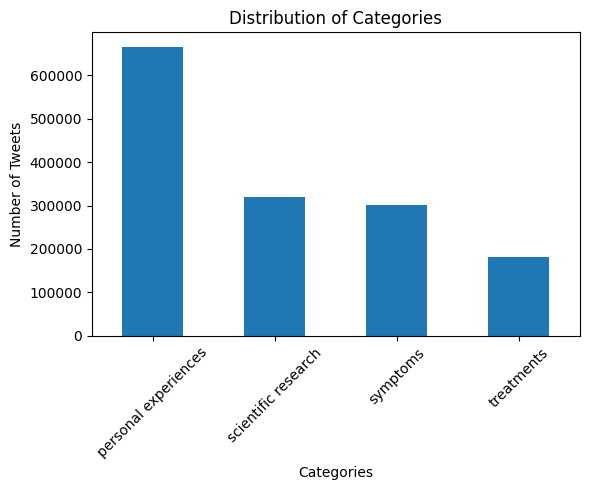

In [42]:
category_counts = df['Category'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 5))
category_counts.plot(kind='bar')
plt.title('Distribution of Categories')
plt.xlabel('Categories')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

([0, 1, 2, 3],
 [Text(0, 0, 'symptoms'),
  Text(1, 0, 'personal experiences'),
  Text(2, 0, 'treatments'),
  Text(3, 0, 'scientific research')])

<Figure size 600x500 with 0 Axes>

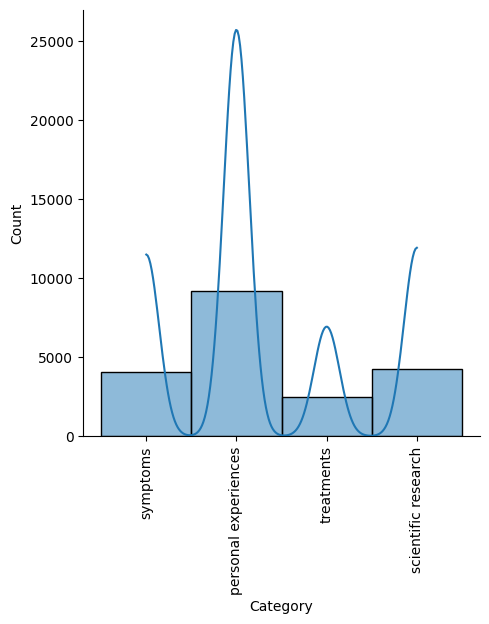

In [46]:
plt.figure(figsize=(6, 5))
sns.displot(sample_data['Category'], bins=3, kde=True)
plt.xticks(rotation=90)